In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger
import tensorboard


import numpy as np



In [101]:
class BasicLSTM(pl.LightningModule):

    def __init__(self, num_feat, num_hiddens, num_out, lr, actfn1 = 'Sigmoid', actfn2 = 'tanh'):
        '''
        num_feat - number of features input into the model
        '''
        super().__init__()
        self.num_feat = num_feat
        self.num_hiddens = num_hiddens
        self.num_out = num_out

        self.lr = lr
        self.act_name_1 = actfn1
        self.act_name_2 = actfn2

        shape_w1 = (num_hiddens,num_feat)
        shape_w2 = (num_hiddens,num_hiddens)
        
        mean = 0.0
        std = 1.0



        #the forget gate weights and bias 
        #(for f_t = sig(wf1 x_t + wf2 h_{t-1} + b_f))
        self.wf1 ,self.wf2, self.bf = self.initWeights(shape_w1, shape_w2, mean, std)

        #the input gate weights and bias
        #(for i_t = sig(wi1 x_t + wi2 h_{t-1} + b_i))
        self.wi1, self.wi2, self.bi = self.initWeights(shape_w1, shape_w2, mean, std) 
        #the output gate weights and bias
        #(for o_t = sig(wo1 x_t + wo2 h_{t-1} + b_o))
        self.wo1, self.wo2, self.bo = self.initWeights(shape_w1, shape_w2, mean, std)
        #the candidate context weights and bias
        #(for c^'_t = sig(wcc1 x_t + wcc2 h_{t-1} + bc_c))
        self.wcc1, self.wcc2, self.bcc = self.initWeights(shape_w1, shape_w2, mean, std)

        self.whq = nn.Parameter(torch.normal(mean=mean,
                                             std=std,
                                             size=(num_hiddens, num_out)),
                                requires_grad=True,
                                )
        self.bq = nn.Parameter(torch.tensor(0.0),
                        requires_grad=True,
                        )

        # print('wf1 \n', self.wf1.shape, '\n wf2 \n', self.wf2.shape, '\n bf \n', self.bf.shape)
        # print('wi1 \n', self.wi1.shape, '\n wi2 \n', self.wi2.shape, '\n bi \n', self.bi.shape)
        # print('wcc1 \n', self.wf1.shape, '\n wcc2 \n', self.wf2.shape, '\n bf \n', self.bcc.shape)
        # print('wo1 \n', self.wo1.shape, '\n wo2 \n', self.wo2.shape, '\n bo \n', self.bo.shape)

    def initWeights(self, shape_w1, shape_w2, mean, std):
        w1 = nn.Parameter(torch.normal(mean=mean,std=std, size=shape_w1),
                                requires_grad=True,
                                )
        w2 = nn.Parameter(torch.normal(mean=mean,std=std,size=shape_w2),
                                requires_grad=True,
                                )
        bias = nn.Parameter(torch.zeros(self.num_hiddens),
                                requires_grad=True,
                                )
        return w1, w2, bias
    
    def actfunc1(self, X, B=0.5):
        '''
        INPUTS:
            X - input into the activation function (originally/defaulting to sigmoid)

            act_name - the name of the desired activation function [str]

        OUTPUTS:
            y1 - the value of the input after being passed through the activation function.
        
        '''


        if self.act_name_1 == 'ReLU':
            n = nn.ReLU(X)
            y1 = n(X)

        elif self.act_name_1 == 'LeakyReLU':
            n=nn.LeakyReLU(0.2)
            y1=n(X)

        elif self.act_name_1 == 'ELU':
            n=nn.ELU()
            y1=n(X)
        
        elif self.act_name_1 == 'SELU':
            n=nn.SELU()
            y1=n(X)

        elif self.act_name_1 == 'arcsinh':
            y1 = torch.arcsinh(B*X)

        elif self.act_name_1 == 'Swish':
            n=nn.SiLU(X)
            y1 = n(X)
        
        else: #act_name == 'Sigmoid'
            n = nn.Sigmoid()
            y1 = n(X)        

        return y1

    def actfunc2(self, X, B = 0.5):
        '''
        INPUTS:
            X - input into the activation function (originally/defaulting to tanh)

            act_name - the name of the desired activation function [str]

        OUTPUTS:
            y2 - the value of the input after being passed through the activation function.
        
        '''

        if self.act_name_2 == 'ReLU':
            m=nn.ReLU()
            y2 = m(X)

        elif self.act_name_2 == 'arcsinh':
            y2 = torch.arcsinh(B*X)

        elif self.act_name_2 == 'Swish':
            m=nn.SiLU()
            y2 = m(X)

        else: #act_name == 'tanh'
            m = nn.Tanh()
            y2=m(X)

        return y2


    def unit(self, val_in, long_mem, short_mem):
        '''
        INPUTS:
            val_in - input into this step of the unit x_t

            long_mem - the long term memory at this step

            short_mem - the short term memory at this step
        OUTPUTS:

        
        '''
        val_in = val_in.float()

        i_t = self.actfunc1((self.wi1@val_in)+(self.wi2@short_mem)+(self.bi))

        f_t = self.actfunc1((self.wf1@val_in)+(self.wf2@short_mem)+(self.bf))
        
        o_t = self.actfunc1((self.wo1@val_in)+(self.wo2@short_mem)+(self.bo))

        cc_t = self.actfunc2((self.wcc1@val_in)+(short_mem@short_mem)+(self.bcc))

        # print('f_t ', f_t)
        # print('i_t ', i_t)
        # print('cc_t ', cc_t)
        # print('o_t ', o_t)

        #update the long term memory (c_t)
        c_t = (f_t*long_mem) + (i_t*cc_t)

        #update the short term memory (h_t)
        h_t = o_t*self.actfunc2(c_t)
        # print('update_short_mem.shape, ', update_short_mem.shape)

        #for multiple inputs we not do a final layer that is just linear
        # Y = (h_t@self.whq) + self.bq
        Y = h_t

        return [Y, c_t, h_t]

    def forward(self, input):
        '''
        in order case input should be an array with multiple inputs for the model.
        The columns are the features and the rows are the days
        '''
        n_seq = np.shape(input)[-1]

        # long_mem = torch.zeros(n_seq, requires_grad=False)
        # short_mem = torch.zeros(n_seq, requires_grad=False)
        long_mem = torch.zeros(self.num_hiddens)
        short_mem = torch.zeros(self.num_hiddens)
        
        for ii in range(0,n_seq):
            # long_mem[ii+1], short_mem[ii+1] = self.unit(input[ii], 
            #                                         long_mem[ii], 
            #                                         short_mem[ii],
            #                                         )
            # print(input[:,ii])
            Y, long_mem, short_mem = self.unit(input[:,ii], 
                                                    long_mem, 
                                                    short_mem,
                                                    )
        return Y


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_indx):

        input_i, label_i = batch
        output_i = self.forward(input_i[0])

        # print(output_i.shape)
        # print(output_i)
        # print(label_i.shape)
        # print(label_i[0,0].shape)
        # print(label_i[0,0])

        loss = (output_i - label_i)**2
        # loss = nn.functional.mse_loss(output_i, label_i)

        # loss = loss.float()

        # self.log("training loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("training loss", loss, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])

        test_loss = (output_i - label_i)**2

        self.log("test_loss", test_loss, on_step=True, logger=True)


    def predict_step(self, batch, batch_idx, dataloader_idx=0):

        return self(batch)

#### Let's test our model with a super simple validation from the StatQuest guy

In [47]:
## create the training data for the neural network.
inputs = torch.tensor([[[0., 0.5, 0.25, 1.]], [[1., 0.5, 0.25, 1.]]])
labels = torch.tensor([0., 1.])

dataset = TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)

In [48]:
mdl_simple = BasicLSTM(num_feat=1, num_hiddens=1, num_out=1, lr=0.01)


In [49]:
print("Company A: Observed = 0, Predicted =", 
      mdl_simple(torch.tensor([[0., 0.5, 0.25, 1.]])).detach())
print("Company B: Observed = 1, Predicted =", 
      mdl_simple(torch.tensor([[1., 0.5, 0.25, 1.]])).detach())

Company A: Observed = 0, Predicted = tensor([0.2254])
Company B: Observed = 1, Predicted = tensor([0.2440])


In [50]:
logger = TensorBoardLogger("lightning_logs", name="simpleModel")

trainer_simple = pl.Trainer(max_epochs=1000,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
trainer_simple.fit(mdl_simple, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
14        Trainable params
0         Non-trainable params
14        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 

Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 123.92it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 88.33it/s, v_num=1] 


In [51]:
trainer_simple.test(mdl_simple,dataloaders=dataloader)

c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 72.71it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch      0.00041241967119276524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.00041241967119276524}]

#### Now let's try to test our model with our stock data

In [53]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, r'C:\Users\Spenc\Documents\GitHub\itcs-8156\utils')

from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

In [54]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
f = r'C:\Users\Spenc\Downloads\archive\Data'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn,False,splitdata=True, stdzr='minmax')

print(X_train.shape)
print(T_train.shape)
# X,T = market_prepro(f,st,sn,False,splitdata=False)

#number of days as features
day_feat = 2

#number of days to use as features
day_targ = 1
day_targ = day_targ - 1

# dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train[['Open','Low']], T_train, 4, 1,None)
# dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test[['Open','Low']], T_test, 4, 1,  None)

dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train, T_train, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])
dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])

(1044, 11)
(1044,)


In [55]:
mdl_stock = BasicLSTM(num_feat=7, num_hiddens=1, num_out=1, lr=0.01)


In [56]:
mdl_stock.forward(ds_train[0][0])

tensor([0.0567], grad_fn=<MulBackward0>)

In [57]:
logger = TensorBoardLogger("lightning_logs", name="market")

trainer = pl.Trainer(max_epochs=10,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
trainer.fit(mdl_stock, train_dataloaders=dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 125.94it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 125.82it/s, v_num=1]


In [58]:
trainer.test(mdl_stock,dataloaders=dl_test)

c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 243.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.009170749718211024
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.009170749718211024}]

#### Looking at the tensorboard test loss vs step it seems like most of the loss is coming from later in the predictions (farther from the training data.)

In [59]:

def makepred(model, dataset):
    y = []
    t = []
    for ii in dataset:
        feat, lab = ii

        y.append(model.forward(feat).detach().numpy()[0])
        t.append(lab.numpy()[0])


    return y, t



In [60]:
y_test, t_test = makepred(mdl_stock, ds_test)
y_train, t_train = makepred(mdl_stock, ds_train)

In [61]:
from sklearn.metrics import (mean_absolute_percentage_error,
                             r2_score,
)

# train_mape = mean_absolute_percentage_error(t_train, y_train)
# test_mape = mean_absolute_percentage_error(t_test, y_test)



# print('Training MAPE ', train_mape)
# print('Testing MAPE ', test_mape)

print('Training r2 ', r2_score(t_train, y_train) )
print('Testing r2 ', r2_score(t_test, y_test) )

Training r2  0.9877127754890505
Testing r2  0.707736736914926


In [62]:
import matplotlib.pyplot as plt

def scatter_results(Y,T,title):
    plt.figure(figsize=(9,9))
    plt.scatter(Y,T)
    plt.xlabel('Model Prediction')
    plt.ylabel('True Value')
    plt.title(title)

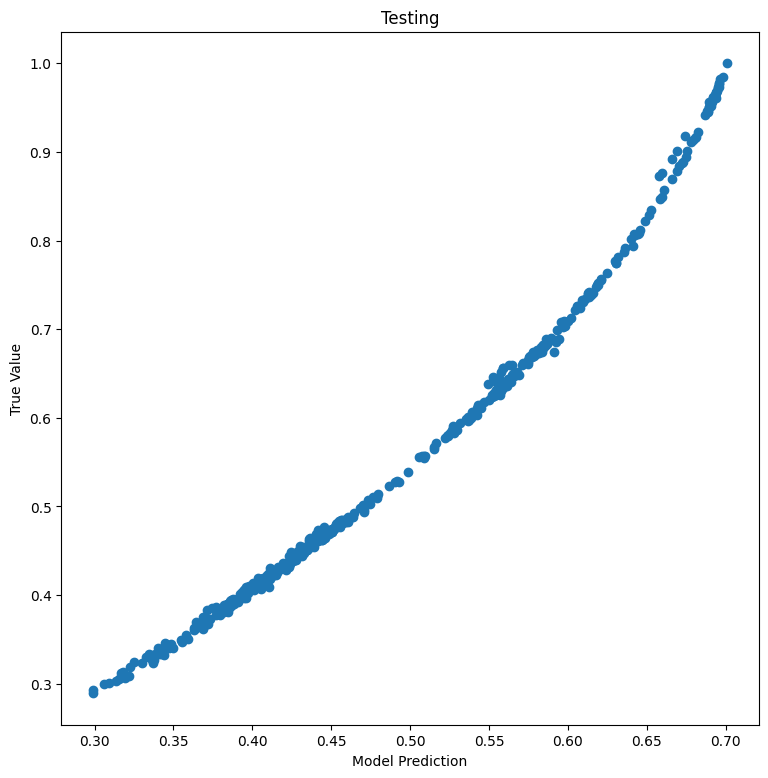

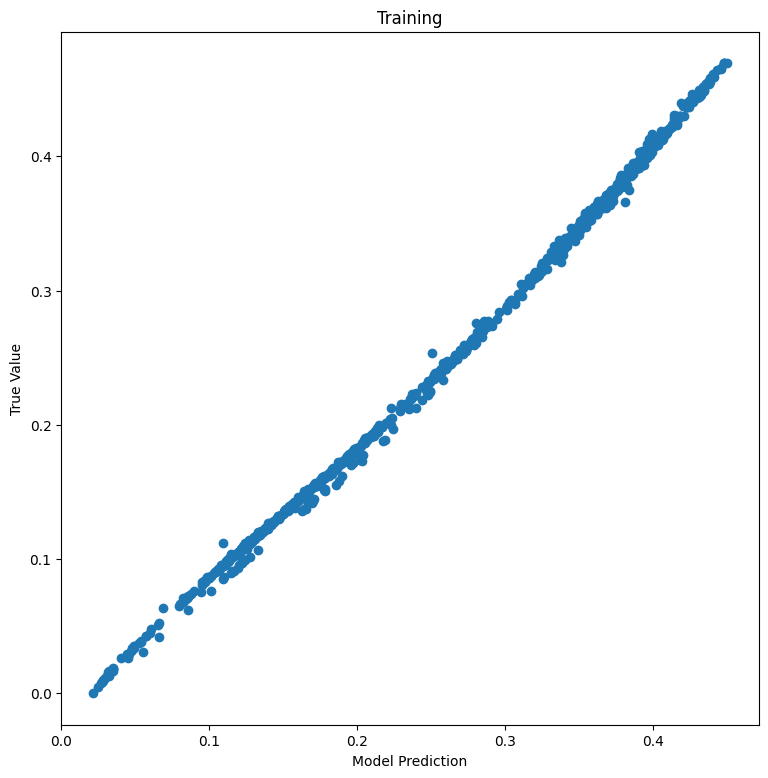

In [63]:
scatter_results(y_test, t_test, 'Testing')
scatter_results(y_train, t_train, 'Training')

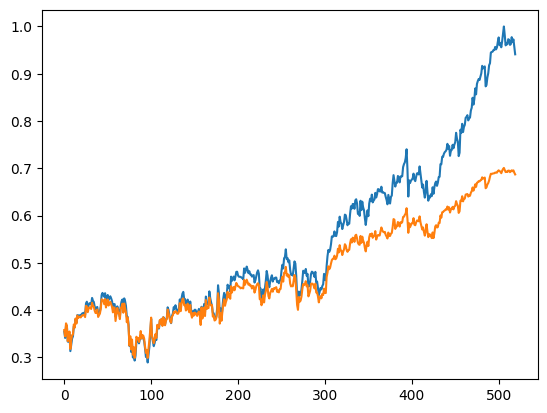

In [64]:
plt.plot(range(len(t_test)),t_test)
plt.plot(range(len(y_test)),y_test)

In [103]:
actfn1_labels = (['Sigmoid', 'ReLU', 'LeakyReLU', 'ELU', 'SELU' 'arcsinh', 'Swish'])
actfn2_labels = (['tanh', 'ReLU', 'arcsinh', 'Swish'])

results = []
for i in range(len(actfn1_labels)):
    act1 = actfn1_labels[i]

    for j in range(len(actfn2_labels)):
        act2 = actfn2_labels[j]
        mdl_stock = BasicLSTM(num_feat=7, num_hiddens=1, num_out=1, lr=0.01, actfn1=act1, actfn2=act2)
        mdl_stock.forward(ds_train[0][0])

        logger = TensorBoardLogger("lightning_logs", name="market")
        trainer = pl.Trainer(max_epochs=10,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
        trainer.fit(mdl_stock, train_dataloaders=dl_train)
        trainer.test(mdl_stock,dataloaders=dl_test)

        y_test, t_test = makepred(mdl_stock, ds_test)
        y_train, t_train = makepred(mdl_stock, ds_train)

        train_score = r2_score(t_train, y_train)
        test_score = r2_score(t_test, y_test)

        add_res = [act1, act2, train_score, test_score]

        results.append(add_res)

display("Activation Fn 1, Activation Fn 2, Training R2, Testing R2")
display(results)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.83it/s, v_num=69]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.73it/s, v_num=69]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 253.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.008126617580623201
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 129.66it/s, v_num=70]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 129.53it/s, v_num=70]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 232.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.009644859381247657
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.42it/s, v_num=71]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.32it/s, v_num=71]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 257.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0021258102345961994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 119.78it/s, v_num=72]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 119.66it/s, v_num=72]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 219.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.06159700297054146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.62it/s, v_num=73]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.52it/s, v_num=73]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 207.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3295769163539683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 124.09it/s, v_num=74]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 123.96it/s, v_num=74]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 245.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3295769163539683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 125.88it/s, v_num=75]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 125.78it/s, v_num=75]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 251.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.3295769163539683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 130.00it/s, v_num=76]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 129.88it/s, v_num=76]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 244.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.026975983243693973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.98it/s, v_num=77]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.87it/s, v_num=77]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 245.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.005619664920970889
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.82it/s, v_num=78]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.69it/s, v_num=78]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 251.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         4.333597043500904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.75it/s, v_num=79]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.63it/s, v_num=79]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 251.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.00892212257879046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 125.53it/s, v_num=80]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 125.41it/s, v_num=80]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 244.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.06547859015737005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.89it/s, v_num=81]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.79it/s, v_num=81]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 242.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.002416880373589096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 129.16it/s, v_num=82]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 129.05it/s, v_num=82]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 240.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.29117443259086306
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.69it/s, v_num=83]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.57it/s, v_num=83]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 245.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0007097025056768413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.30it/s, v_num=84]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.18it/s, v_num=84]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 235.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.23859156387731206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.17it/s, v_num=85]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.06it/s, v_num=85]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 243.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.007254738454923292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:07<00:00, 131.11it/s, v_num=86]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:07<00:00, 131.00it/s, v_num=86]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 244.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.04605514195130534
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 124.42it/s, v_num=87]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 124.32it/s, v_num=87]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 236.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       9.528742846131283e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 130.28it/s, v_num=88]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 130.17it/s, v_num=88]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 242.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.09052856706796965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.73it/s, v_num=89]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 127.62it/s, v_num=89]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 249.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.001305896193752922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.62it/s, v_num=90]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.52it/s, v_num=90]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 248.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.31323823293829556
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.70it/s, v_num=91]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 126.60it/s, v_num=91]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 251.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.008364052126680047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.85it/s, v_num=92]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1043/1043 [00:08<00:00, 128.74it/s, v_num=92]


c:\Users\Spenc\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 520/520 [00:02<00:00, 245.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.25767651846770645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


'Activation Fn 1, Activation Fn 2, Training R2, Testing R2'

[['Sigmoid', 'tanh', 0.9905304332588369, 0.7410122569105737],
 ['Sigmoid', 'ReLU', 0.990478585698917, 0.6926273029605685],
 ['Sigmoid', 'arcsinh', 0.9989916618185791, 0.9322524052064164],
 ['Sigmoid', 'Swish', 0.9730257678081576, -0.9630391884626934],
 ['ReLU', 'tanh', -3.956516642018072, -9.503309758835874],
 ['ReLU', 'ReLU', -3.956516642018072, -9.503309758835874],
 ['ReLU', 'arcsinh', -3.956516642018072, -9.503309758835874],
 ['ReLU', 'Swish', 0.6036649434069892, 0.14030050650338122],
 ['LeakyReLU', 'tanh', 0.9978822534658822, 0.8209065062602025],
 ['LeakyReLU', 'ReLU', 0.9271281530739451, -137.10770675753156],
 ['LeakyReLU', 'arcsinh', 0.9817721556151204, 0.7156602525806374],
 ['LeakyReLU', 'Swish', 0.9971947382547711, -1.0867417615379331],
 ['ELU', 'tanh', 0.9954127803675299, 0.9229762706239011],
 ['ELU', 'ReLU', -2.916280918195024, -8.279458322470854],
 ['ELU', 'arcsinh', 0.9907080810311122, 0.9773824412940986],
 ['ELU', 'Swish', 0.920228599564449, -6.603691208024474],
 ['SELUarc